## Multivariate - Only Economic and Demographic Factors

#### Importing Packages

In [457]:
import pandas as pd
import numpy as np
import requests
import json
import os
import time
import fred_msa
import ts_functions
import datetime as dt
from datetime import date
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import sklearn
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.filterwarnings('ignore')

#### Ingesting Data

In [73]:
hpi = pd.read_csv('..\\working-data\\hpi-data.csv')
hpi = hpi.query("year <= 2019")
hpi = hpi.dropna()
hpi.date = pd.to_datetime(hpi.date)
#hpi = hpi.set_index(['city', 'msa_state', 'date'])

**Looking at correlation between HPI and other factors across all cities**

In [74]:
data_cols = ['hpi', 'weekly_wages', 'rpp', 'population', 'gdp', 'unemployment_rate', 'crimes', 'subprime', 'poverty', 'patents', 'private_establishments', 'premature_death_rate', 'snap']

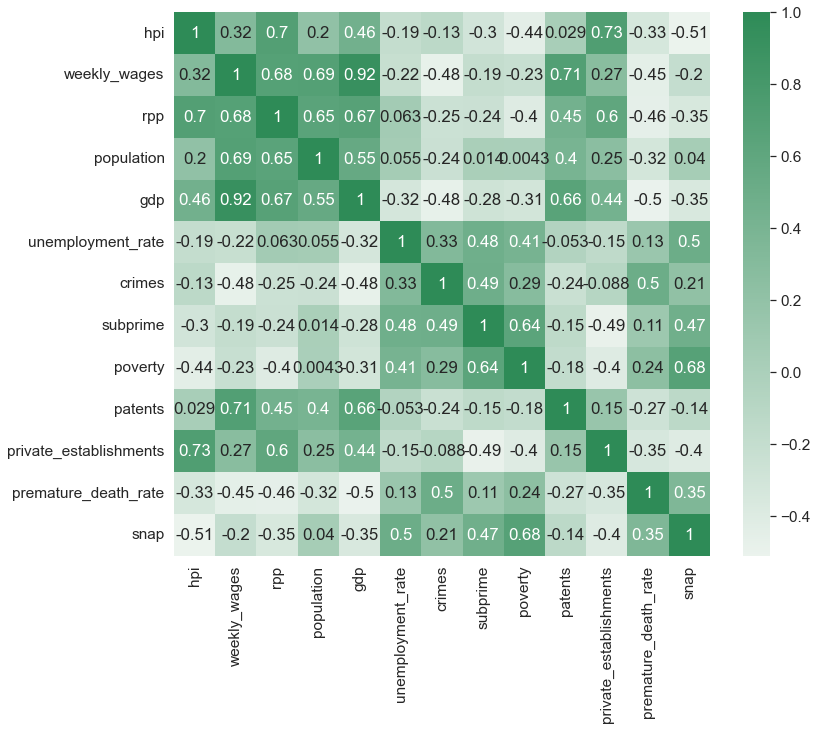

In [75]:
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)
sns.heatmap(hpi[data_cols].corr(), cmap=sns.light_palette("seagreen", as_cmap=True), annot=True)
plt.show()

At the macro level we can see a few trends emerge already. It seems that HPI is most highly related to regional price parity, GDP per capita, and private establishments per capita on the positive side, and with proportion of the population in poverty and recieving SNAP benefits on the negative end.

Let's get a baseline by seeing how well we can predict HPI based on *just* exogenous variables, without taking into account time trends or city-by-city variations.

*Note - I don't expect this to be very accurate, but it should serve as an informative comparison for more nuanced models.*

### Predicting HPI without location or time

#### Prepping Model

In [268]:
X = hpi[data_cols].drop(columns='hpi')
X = (X - X.mean())/X.std()
y = np.log(np.array(hpi.hpi))

#### Method 1 - Penalized Logistic Regression

In [269]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2022)

**Highest Correlation Predictors**

In [295]:
ridge_model = Ridge(random_state=2023, alpha=2)
lasso_model = Lasso(random_state=2022, alpha=0)

We will cross-validate, and use sufficiently high levels of $\alpha$ to reduce the input space.

In [341]:
coefs_ridge = np.empty(shape=(0,5))
coefs_lasso = np.empty(shape=(0,5))
r2s_lasso = []
r2s_ridge = []
lasso_mses = []
ridge_mses = []


for train_index, test_index in rkf.split(X):
    X_train, X_test = np.array(X[best_predictors])[train_index], np.array(X[best_predictors])[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ridge_model = Ridge(random_state=2023, alpha=0.2).fit(X_train, y_train)
    lasso_model = Lasso(random_state=2022, alpha=0.2).fit(X_train, y_train)
    
    coefs_ridge = np.concatenate([coefs_ridge, ridge_model.coef_.reshape(1,5)])
    coefs_lasso = np.concatenate([coefs_lasso, lasso_model.coef_.reshape(1,5)])
    r2s_lasso.append(lasso_model.score(X_train, y_train))
    lasso_mses.append(MSE(np.exp(y_test), np.exp(lasso_model.predict(X_test))))
    r2s_ridge.append(ridge_model.score(X_train, y_train))
    ridge_mses.append(MSE(np.exp(y_test), np.exp(ridge_model.predict(X_test))))

**R-Squared**

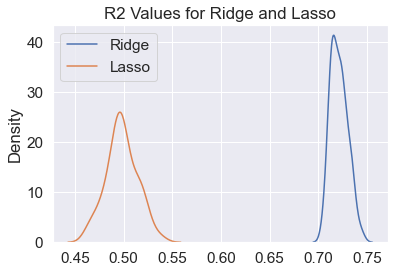

In [314]:
sns.kdeplot(r2s_ridge, label='Ridge')
sns.kdeplot(r2s_lasso, label='Lasso')
plt.title('R2 Values for Ridge and Lasso')
plt.legend()
plt.show()

**MSE**

In [347]:
lasso_pct_errors = np.sqrt(lasso_mses)/hpi.hpi.mean()
ridge_pct_errors = np.sqrt(ridge_mses)/hpi.hpi.mean()

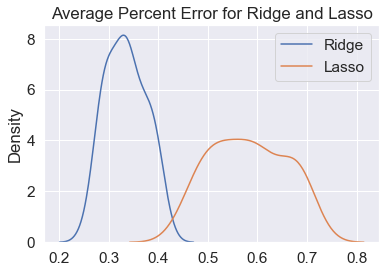

In [349]:
sns.kdeplot(ridge_pct_errors, label='Ridge')
sns.kdeplot(lasso_pct_errors, label='Lasso')
plt.title('Average Percent Error for Ridge and Lasso')
plt.legend()
plt.show()

**These models are terrible! Let's see if a further reduced model makes a difference.**

*Selecting variables for further reduced model.*

In [363]:
magnitudes = pd.DataFrame({'variable': best_predictors, 'ridge_magnitude' : np.abs(coefs_ridge.mean(axis=0)), 'lasso_magnitude' : np.abs(coefs_lasso.mean(axis=0))})

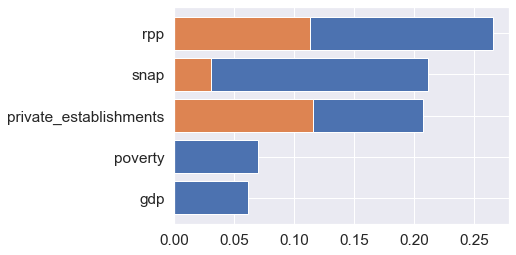

In [367]:
plt.barh(data=magnitudes.sort_values(['ridge_magnitude']), y='variable', width='ridge_magnitude')
plt.barh(data=magnitudes.sort_values(['lasso_magnitude']), y='variable', width='lasso_magnitude')
plt.show()

**Use $rpp$, $snap$, $private \_ establishments$ for further reduced model.**

In [370]:
coefs_ridge = np.empty(shape=(0,3))
coefs_lasso = np.empty(shape=(0,3))
r2s_lasso = []
r2s_ridge = []
lasso_mses = []
ridge_mses = []
reduced = ['rpp', 'snap', 'private_establishments']

for train_index, test_index in rkf.split(X):
    X_train, X_test = np.array(X[reduced])[train_index], np.array(X[reduced])[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ridge_model = Ridge(random_state=2023, alpha=0.05).fit(X_train, y_train)
    lasso_model = Lasso(random_state=2022, alpha=0.05).fit(X_train, y_train)
    
    coefs_ridge = np.concatenate([coefs_ridge, ridge_model.coef_.reshape(1,3)])
    coefs_lasso = np.concatenate([coefs_lasso, lasso_model.coef_.reshape(1,3)])
    r2s_lasso.append(lasso_model.score(X_train, y_train))
    lasso_mses.append(MSE(np.exp(y_test), np.exp(lasso_model.predict(X_test))))
    r2s_ridge.append(ridge_model.score(X_train, y_train))
    ridge_mses.append(MSE(np.exp(y_test), np.exp(ridge_model.predict(X_test))))

**R-Squared**

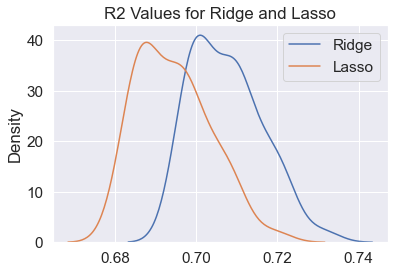

In [371]:
sns.kdeplot(r2s_ridge, label='Ridge')
sns.kdeplot(r2s_lasso, label='Lasso')
plt.title('R2 Values for Ridge and Lasso')
plt.legend()
plt.show()

**MSE**

In [372]:
lasso_pct_errors = np.sqrt(lasso_mses)/hpi.hpi.mean()
ridge_pct_errors = np.sqrt(ridge_mses)/hpi.hpi.mean()

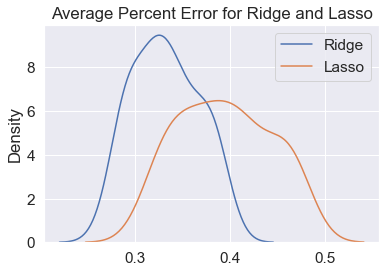

In [373]:
sns.kdeplot(ridge_pct_errors, label='Ridge')
sns.kdeplot(lasso_pct_errors, label='Lasso')
plt.title('Average Percent Error for Ridge and Lasso')
plt.legend()
plt.show()

**Still awful, but now we suspect that $rpp$, $snap$, and $private \_ establishments$ are the biggest drivers of between-city variance. Confirming this suspicion using tree-based models.**

### Method 2- Random Forest

In [458]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, np.exp(y), test_size=0.25, random_state=2024)

In [459]:
rf_model = RandomForestRegressor(n_estimators = 1000, max_features=int(X.shape[1]/3), max_depth=3, min_samples_leaf=5, oob_score=True)
gb_model = GradientBoostingRegressor(n_estimators = 1000, max_features=int(X.shape[1]/3), max_depth=3, min_samples_leaf=5)

In [460]:
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_features=4, min_samples_leaf=5, n_estimators=1000)

In [485]:
rf_pct_error_train = (np.sqrt((rf_model.predict(X_train) - np.array(y_train)) **2)/y_train).mean()
gb_pct_error_train = (np.sqrt((gb_model.predict(X_train) - np.array(y_train)) **2)/y_train).mean()

rf_pct_error_holdout = (np.sqrt((rf_model.predict(X_holdout) - np.array(y_holdout)) **2)/y_holdout).mean()
gb_pct_error_holdout = (np.sqrt((gb_model.predict(X_holdout) - np.array(y_holdout)) **2)/y_holdout).mean()

print(f'Random Forest Train Error: {rf_pct_error_train:.3f}\nGradient Boosting Train Error: {gb_pct_error_train:.3f}')
print(f'Random Forest Holdout Error: {rf_pct_error_holdout:.3f}\nGradient Boosting Holdout Error: {gb_pct_error_holdout:.3f}')

Random Forest Train Error: 0.227
Gradient Boosting Train Error: 0.006
Random Forest Holdout Error: 0.214
Gradient Boosting Holdout Error: 0.036


In [486]:
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_
rf_std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
gb_std = np.std([tree.feature_importances_ for tree in gb_model.estimators_], axis=0)

AttributeError: 'numpy.ndarray' object has no attribute 'feature_importances_'

In [487]:
gb_importances

array([0.00880288, 0.32904904, 0.06137929, 0.01496421, 0.02066902,
       0.03623605, 0.09214022, 0.0513865 , 0.01677384, 0.31143226,
       0.03481306, 0.02235363])

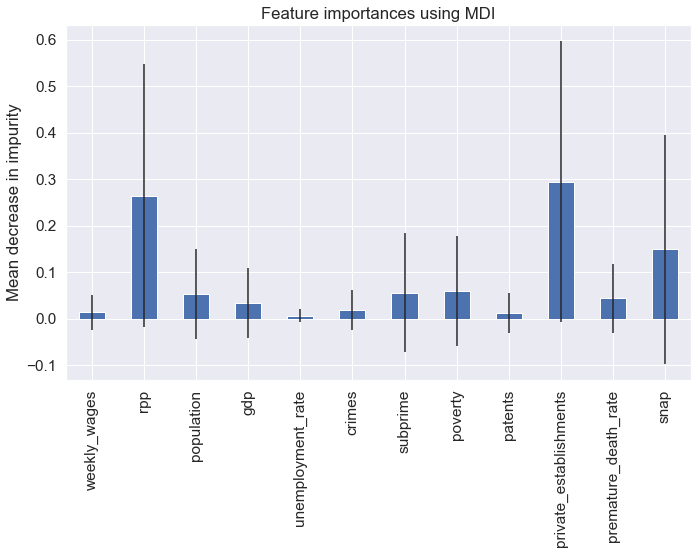

In [446]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots(figsize=(10,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**This shows slight improvement on error, and confirms our suspicions about the best predictors of between-city variance. Moving on to within-city variance.**

### Method 1 - Using City as another predictor

In [418]:
pd.DataFrame({'variable' : X.columns, ''rf_model.feature_importances_

array([0.0146081 , 0.26527857, 0.05565939, 0.02854795, 0.0062082 ,
       0.02135647, 0.06592253, 0.05560329, 0.0123545 , 0.28608133,
       0.04156646, 0.14681322])

In [393]:
X.columns

Index(['weekly_wages', 'rpp', 'population', 'gdp', 'unemployment_rate',
       'crimes', 'subprime', 'poverty', 'patents', 'private_establishments',
       'premature_death_rate', 'snap'],
      dtype='object')

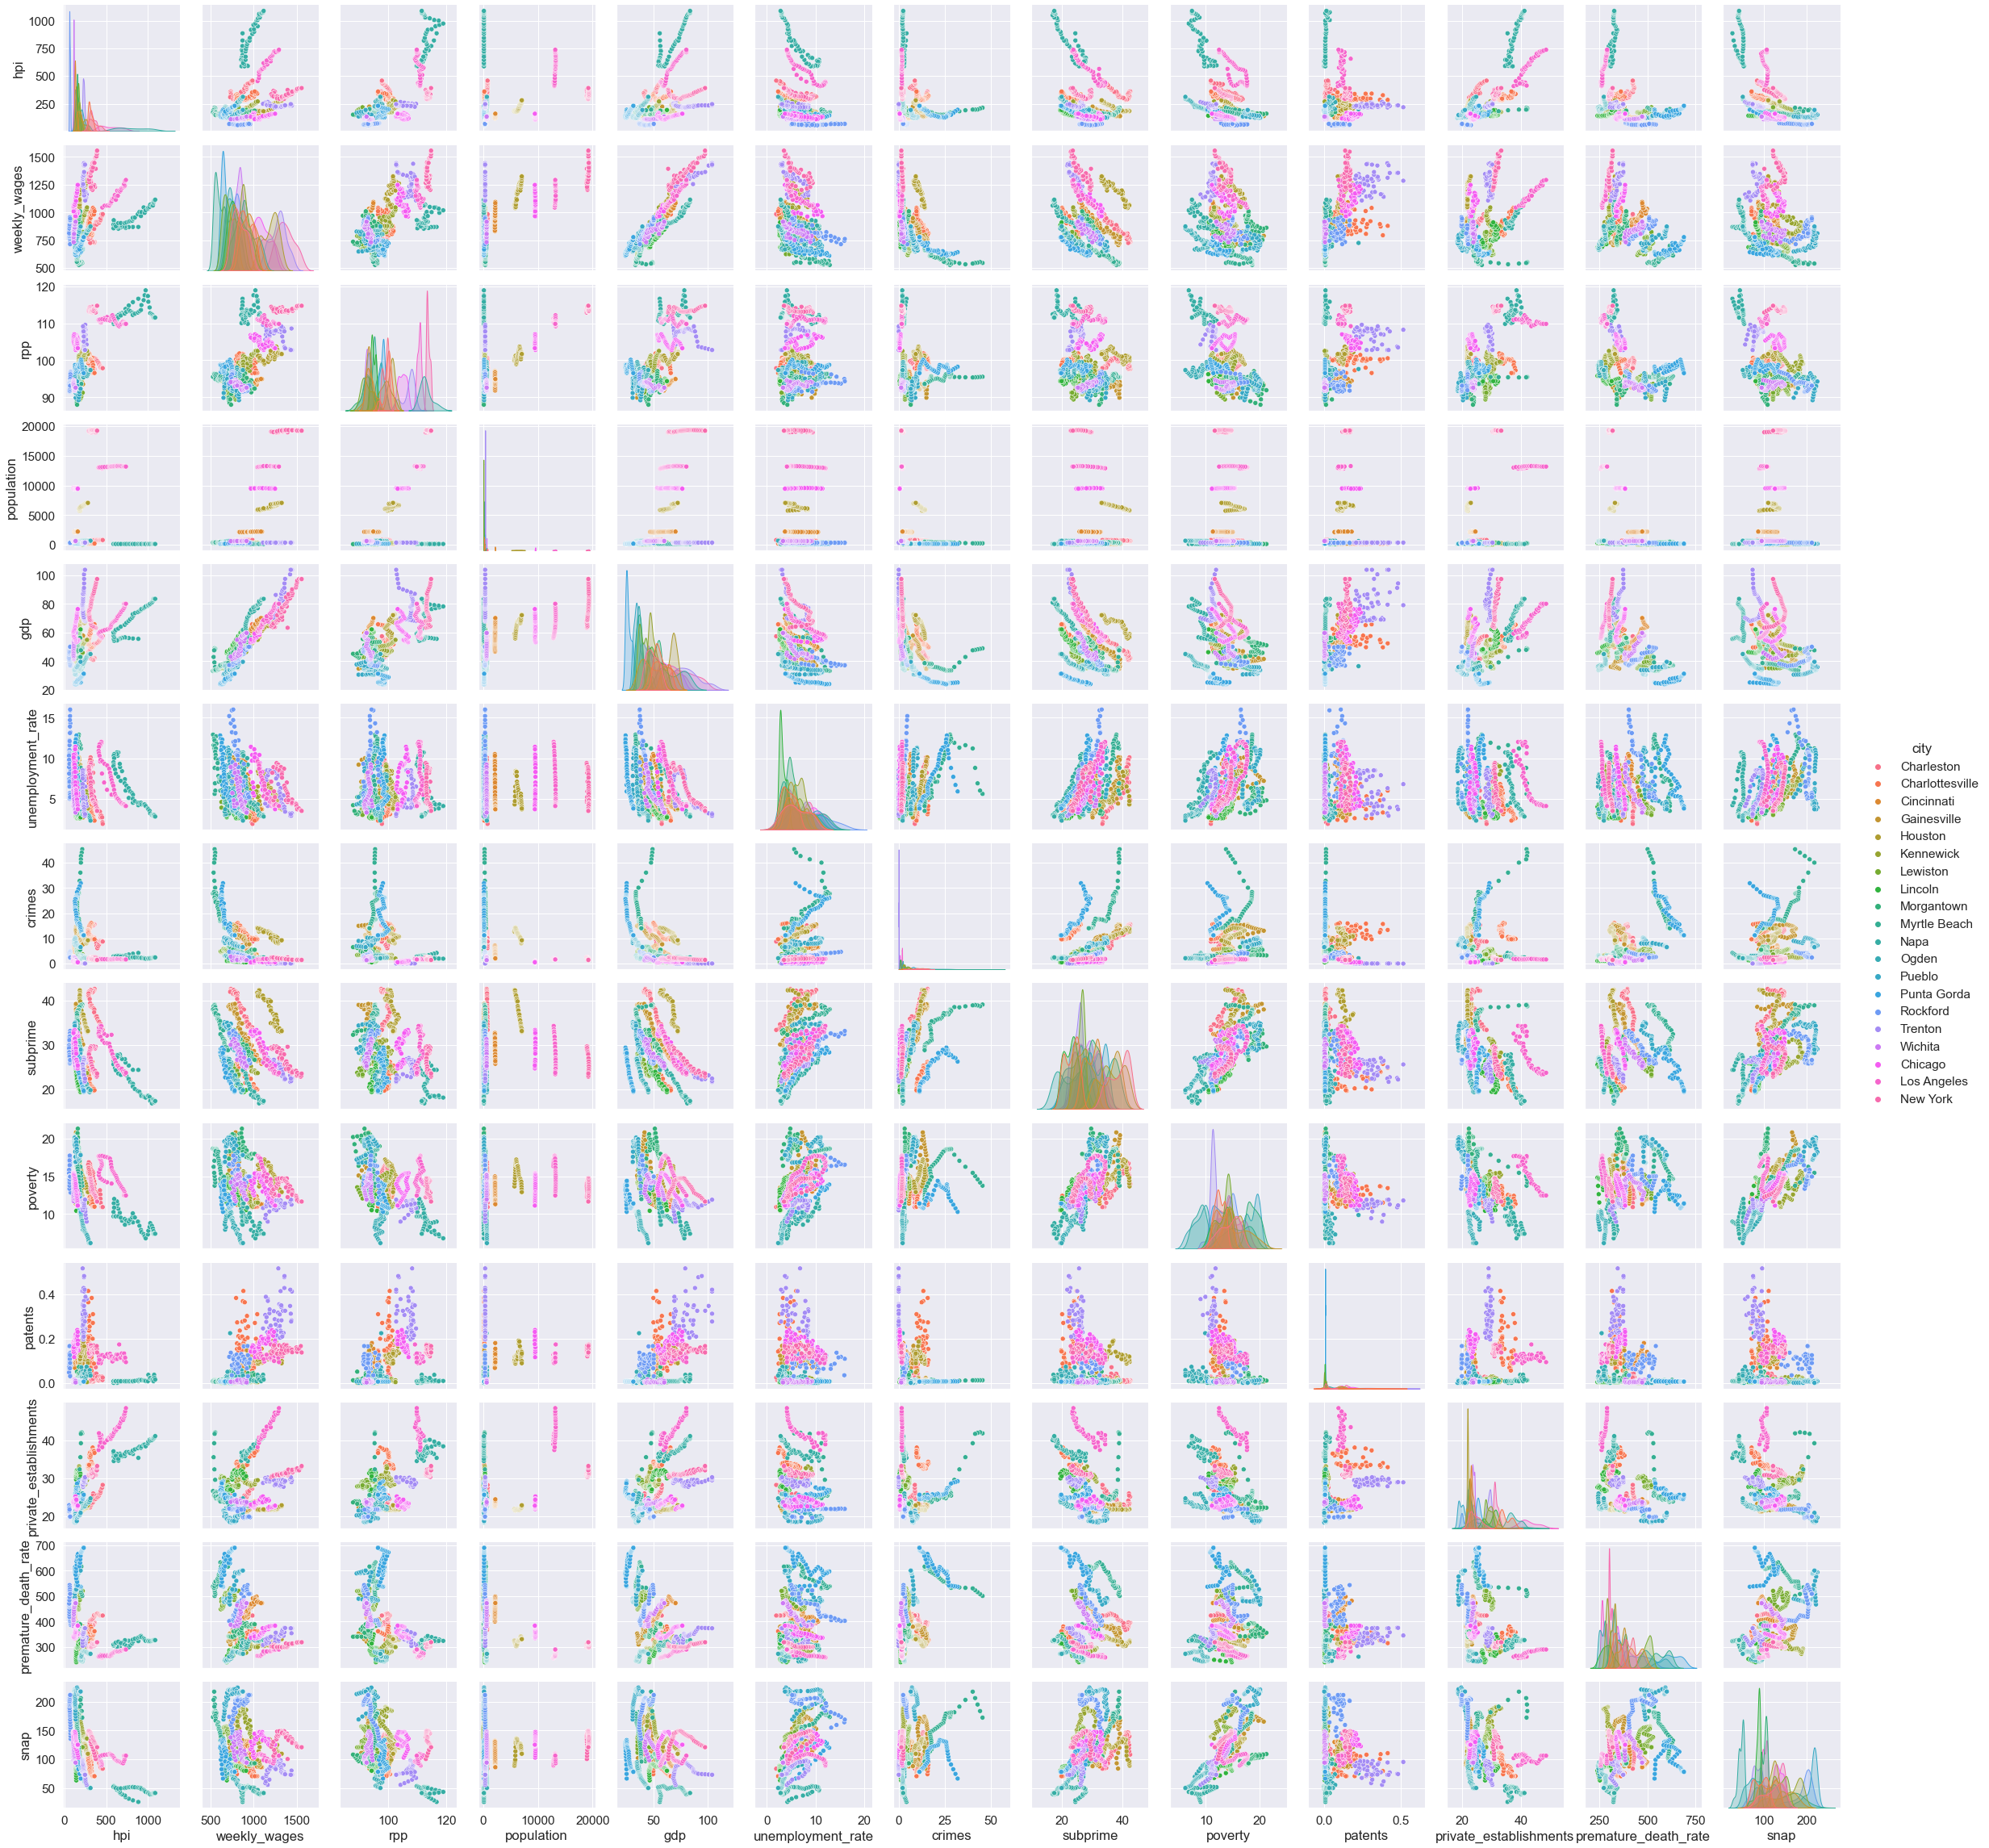

In [23]:
sns.pairplot(data = hpi[data_cols + ['city']], hue='city')

In [7]:
hpi.groupby(['city'])[data_cols]

In [6]:
hpi.groupby(['city'])[data_cols].diff()

,hpi,weekly_wages,rpp,population,gdp,unemployment_rate,crimes,subprime,poverty,patents,private_establishments,premature_death_rate,snap
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-5.610195,-5.397252,0.02250,2.99925,-84.69275,0.3,-24.500000,-0.343362,0.371327,-1.000000,483.0,-2.19088,4002.75
2,-11.180126,4.300450,0.02250,2.99925,-84.69275,0.9,-24.500000,-0.064717,0.371327,-2.000000,200.0,-2.19088,4002.75
3,-3.274851,-0.799630,0.02250,2.99925,-84.69275,1.0,-24.500000,0.038690,0.371327,0.500000,-280.0,-2.19088,4002.75
4,3.113793,0.785735,0.02250,2.99925,-84.69275,1.2,-24.500000,-0.231891,0.371327,-0.833333,-834.0,-2.19088,4002.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,3.311712,1.197416,0.08125,-14.23150,20326.85650,-0.1,-61.666667,0.502047,-0.164816,261.393939,4446.0,0.55486,-22097.00
956,4.839242,22.081334,0.08125,-14.23150,20326.85650,0.1,-61.666667,-0.493502,-0.164816,-16.931818,-10464.0,0.55486,-22097.00
957,-1.007832,19.808997,0.00000,0.00000,0.00000,-0.2,0.000000,-0.396668,0.000000,253.250000,13969.0,0.00000,0.00
958,2.818923,6.134153,0.00000,0.00000,0.00000,-0.1,0.000000,0.234303,0.000000,-525.500000,3977.0,0.00000,0.00
